# 台股 ModERP 策略實作
- 本實作使用之 finlab library 來自 hahow 課程 [用 Python 理財：打造小資族選股策略](https://hahow.in/courses/5a2170d5a6d4a5001ec3148d/)，提供台股股價、月季報數據擷取、回測框架等功能。因著作權法，本實作不提供 finlab library 之 source code。
- ModERP 策略實作細節來自 Quant Investing 網站文章 [DOES SYSTEMATIC VALUE INVESTING REALLY WORK? – DATA DRIVEN BACKTEST](https://www.quant-investing.com/blogs/general/2018/05/17/does-systematic-value-investing-really-work-data-driven-backtest)，該文章比較了幾個著名價值投資策略，例如 Magic Formula、ERP5、F-Score、以及各策略混合使用在歐股的回測績效。本人也將文中各種策略在台股進行實證，最後發現 ModERP 策略表現最佳，再經過一些優化使年化報酬率表現得更好。
- 若需要暸解各財務指標詳細計算方法、所採用會計科目，可利用 Quant Investing 網站之 [Glossary
](https://www.quant-investing.com/screener/glossary) 進行查詢。
- 文末策略評估方法、以及停損點設定準則，參考外匯量化交易神人粗手指大大（王睿麒）在[量化投資研究社](https://www.facebook.com/groups/pyquant/)的第一場 Meetup [簡報](https://docs.google.com/presentation/d/1o-tSWGh-a2JgPtHuMXWr4fT5KMUAK9CzaWqWDJnW5Ng/edit#slide=id.g35f391192_00)。

### 1. 由於台股損益表之表示方式為累進制，須扣除當年度前幾季財報，以計算出當季實際損益。

In [1]:
%matplotlib inline

import pandas as pd
from finlab.data import Data
import datetime

def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')
    
    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()

### 2.1 計算 F-Score 中之 Profitability 指標

In [2]:
def totalAssets(data, window):
    return data.get('資產總計', window).fillna(data.get('資產總額', window))

def ROA(data):
    return data.get('本期淨利（淨損）', 1).iloc[-1] / totalAssets(data, 1).iloc[-1]

def CFROA(data):
    return toSeasonal(data.get('營業活動之淨現金流入（流出）', 5)).iloc[-1] / totalAssets(data, 1).iloc[-1]

def ROAYoY(data):
    currentROA = ROA(data)
    lastYearROA = data.get('本期淨利（淨損）', 5).iloc[0] / totalAssets(data, 5).iloc[0]
    return currentROA - lastYearROA

def CFROAtoROA(data):
    return CFROA(data) - ROA(data)

### 2.2 計算 F-Score 中之 Funding 指標

In [3]:
def gearing(data):
    longTermDebt = data.get('非流動負債合計', 5)
    averageTotalAssets = totalAssets(data, 5)
    currentGearing = longTermDebt.iloc[-1] / averageTotalAssets.iloc[-1]
    lastYearGearing = longTermDebt.iloc[0] / averageTotalAssets.iloc[0]
    return currentGearing - lastYearGearing
    
def liquidity(data):
    assets = data.get('流動資產合計', 5)
    liabilities = data.get('流動負債合計', 5)
    currentLiquidity = assets.iloc[-1] / liabilities.iloc[-1]
    lastYearLiquidity = assets.iloc[0] / liabilities.iloc[0]
    return currentLiquidity - lastYearLiquidity

def sharesInIssue(data):
    sharesInIssue = data.get('股本合計', 5)
    return data.get('股本合計', 5).iloc[-1] - data.get('股本合計', 5).iloc[0]

### 2.3 計算 F-Score 中之 Efficiency 指標

In [4]:
def grossMargin(data):
    grossProfit = data.get('營業毛利（毛損）淨額', 5)
    sales = data.get('營業收入合計', 5)
    currentGrossMargin = grossProfit.iloc[-1] / sales.iloc[-1]
    lastYearGrossMargin = grossProfit.iloc[0] / sales.iloc[0]
    return currentGrossMargin - lastYearGrossMargin
    
def assetTurnover(data):
    totalSales = data.get('營業收入合計', 5)
    ta = totalAssets(data, 5)
    currentAssetTurnover = totalSales.iloc[-1] / ta.iloc[-1]
    lastYearAssetTurnover = totalSales.iloc[0] / ta.iloc[0]
    return currentAssetTurnover - lastYearAssetTurnover

### 2.4 將 F-Score 分數加總，數字越大越好，最高為 9 分

In [5]:
def f_score(data):
    return ROA(data).apply(lambda data: 1 if data > 0 else 0) + \
        CFROA(data).apply(lambda data: 1 if data > 0 else 0) + \
        ROAYoY(data).apply(lambda data: 1 if data > 0 else 0) + \
        CFROAtoROA(data).apply(lambda data: 1 if data > 0 else 0) + \
        gearing(data).apply(lambda data: 1 if data < 0 else 0) + \
        liquidity(data).apply(lambda data: 1 if data > 0 else 0) + \
        sharesInIssue(data).apply(lambda data: 1 if data <= 0 else 0) + \
        grossMargin(data).apply(lambda data: 1 if data > 0 else 0) + \
        assetTurnover(data).apply(lambda data: 1 if data > 0 else 0)

### 3. 計算 ERP5 策略需要之指標

In [6]:
def earningsYield(data):
    EBIT = data.get('繼續營業單位稅前淨利（淨損）', 1).iloc[-1]
    EV = data.get('股本合計', 1).iloc[-1]/10 * data.get('收盤價', 1).iloc[-1] + data.get('負債總計', 1).fillna(data.get('負債總額', 1)).iloc[-1] - data.get('現金及約當現金', 1).fillna(data.get('現金及約當現金合計', 1)).fillna(data.get('現金及約當現金總額', 1)).iloc[-1]
    return EBIT/EV

def earningsYieldRanking(data):
    stocks = earningsYield(data).sort_values(ascending=True)[lambda data: data > 0]
    return pd.Series(list(range(0, stocks.size)), index = stocks.index)

def ROIC(data):
    EBIT = data.get('繼續營業單位稅前淨利（淨損）', 1).iloc[-1]
    IC = totalAssets(data, 1).iloc[-1] - data.get('流動負債合計', 1).fillna(data.get('流動負債總額', 1)).iloc[-1]
    return EBIT/IC

def ROICRanking(data):
    stocks = ROIC(data).sort_values(ascending=True)[lambda data: data > 0]
    return pd.Series(list(range(0, stocks.size)), index = stocks.index)

def nYearROIC(data, year):
    EBIT = data.get('繼續營業單位稅前淨利（淨損）', year*4).sum()
    IC = totalAssets(data, year*4).sum() - data.get('流動負債合計', year*4).fillna(data.get('流動負債總額', year*4)).sum()
    return EBIT/IC

def nYearROICRanking(data, year):
    stocks = nYearROIC(data, year).sort_values(ascending=True)[lambda data: data > 0]
    return pd.Series(list(range(0, stocks.size)), index = stocks.index)

def PB(data):
    book_value = totalAssets(data, 1).iloc[-1] - data.get('負債總計', 1).fillna(data.get('負債總額', 1)).iloc[-1]
    return (data.get('股本合計', 1).iloc[-1]/10 * data.get('收盤價', 1).iloc[-1])/book_value

def PBRanking(data):
    stocks = PB(data).sort_values(ascending=False)[lambda data: data > 0]
    return pd.Series(list(range(0, stocks.size)), index = stocks.index)

### 4. 計算優化策略需要之成長性指標

In [7]:
#data = Data()
#data.col2table['折舊費用'] = 'cash_flows'
#data.col2table['攤銷費用'] = 'cash_flows'
#data.date = datetime.date(2014, 5, 15)

def 月營收年增率(data):
    return data.get('去年同月增減(%)', 1).iloc[-1]

def 營業利益成長率(data):
    營業利益 = data.get('營業利益（損失）', 5)
    return 營業利益.iloc[-1] / 營業利益.iloc[-5] - 1

def FCF(data):
    income = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    outcome = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    return (income + outcome).iloc[-1]

def rsv(data, days):
    price = data.get('收盤價', days)
    return (price.iloc[-1] - price.iloc[-days:].min()) / (price.iloc[-days:].max() - price.iloc[-days:].min())

### 5. 實作 F-Score、ModERP、ERPPiot 三種策略
- F-Score 策略說明：從 9 分開始，選出大於 10 檔 F-Scrore 分數最高、且 RSV 指標大於 0.9 的股票
- ModERP 策略說明：先挑出 F-Score 分數大於 6 的股票，再依據 ERP5 分數做排序，最後選擇 10 檔相對便宜的好公司
- ERPPiot 策略說明：先依據 ERP5 分數做排序，選擇前 20% 相對便宜的好公司，再依據 F-Score，挑出分數最高的前 10 檔股票

In [8]:
data = Data()
data.col2table['折舊費用'] = 'cash_flows'
data.col2table['攤銷費用'] = 'cash_flows'

def fscore(data):
    f_score_stocks = f_score(data)
    rsv_stocks = rsv(data, 120)
    
    def select_stocks(score):
        stocks = pd.concat([f_score_stocks, rsv_stocks], axis=1, keys=['fscore', 'rsv'])
        filter_stocks = stocks[stocks.fscore >= score][stocks.rsv > 0.9]
        return pd.Series() if score == 0 else filter_stocks if filter_stocks.index.size >= 10 else select_stocks(score - 1)
    return select_stocks(9)

def ModERP(data):
    fscore = f_score(data)
    erp5 = earningsYieldRanking(data) + ROICRanking(data) + PBRanking(data) + nYearROICRanking(data, 5)
    #stocks = pd.concat([fscore, erp5, rsv(data, 120)], axis=1, keys=['fscore', 'erp5', 'rsv'])
    #return stocks[stocks.fscore >= 7][stocks.rsv > 0.9].sort_values(ascending=False, by='erp5').drop('2408', errors='ignore').head(10)
    stocks = pd.concat([fscore, erp5, 月營收年增率(data), 營業利益成長率(data), FCF(data), rsv(data, 120),], axis=1, keys=['fscore', 'erp5', '月營收年增率', '營業利益成長率', 'FCF', 'rsv'])
    return stocks[stocks.fscore >= 6][stocks.月營收年增率 > 0][stocks.營業利益成長率 > 0][stocks.FCF > 0][stocks.rsv > 0.9].sort_values(ascending=False, by='erp5').drop('2408', errors='ignore').head(10)

def ERPPiot(data):
    erp5 = earningsYieldRanking(data) + ROICRanking(data) + PBRanking(data) + nYearROICRanking(data, 5)
    erp5_stocks = erp5.sort_values(ascending=False).head(int(erp5.size*0.2))
    fscore = f_score(data)
    stocks = pd.concat([erp5_stocks, fscore], axis=1, keys=['erp5', 'fscore'])
    def filter_stocks(f_score):
        filter = stocks[stocks.fscore >= f_score]
        return filter if filter.index.size > 0 else filter_stocks(f_score - 1)
    return filter_stocks(9)

### 6. 回測數據為 2014-5-15 至 2018-8-14，每一季報發佈日做再平衡
- 經過回測，ModERP 在以上策略中表現最佳。
- 以下為 ModERP 的回測數據，並經過月營收年增率、營業利益成長率、自由現金流量、RSV 等指標的優化，取得最高年化報酬率。
- 注意因回測框架並未考慮因公司減資所造成之股票價差情形，所以報酬率會有一些誤差

2014-05-15 - 2014-08-14 報酬率: 7.54 % number of stocks 10
2014-08-14 - 2014-11-14 報酬率: -0.03 % number of stocks 9
2014-11-14 - 2015-03-31 報酬率: 54.11 % number of stocks 6
2015-03-31 - 2015-05-15 報酬率: -0.36 % number of stocks 10
2015-05-15 - 2015-08-14 報酬率: -1.80 % number of stocks 10
2015-08-14 - 2015-11-14 報酬率: -2.35 % number of stocks 3
2015-11-14 - 2016-03-31 報酬率: 16.83 % number of stocks 10
2016-03-31 - 2016-05-15 報酬率: -5.10 % number of stocks 10
2016-05-15 - 2016-08-14 報酬率: 17.82 % number of stocks 10
2016-08-14 - 2016-11-14 報酬率: 1.56 % number of stocks 10
2016-11-14 - 2017-03-31 報酬率: 8.46 % number of stocks 10
2017-03-31 - 2017-05-15 報酬率: 0.72 % number of stocks 10
2017-05-15 - 2017-08-14 報酬率: 4.05 % number of stocks 10
2017-08-14 - 2017-11-14 報酬率: 2.37 % number of stocks 3
2017-11-14 - 2018-03-31 報酬率: 25.39 % number of stocks 10
2018-03-31 - 2018-05-15 報酬率: 14.59 % number of stocks 10
2018-05-15 - 2018-08-14 報酬率: -2.22 % number of stocks 10
年化報酬 : 33.66 ％
每次換手最大報酬 : 54.11 ％
每次換手最少報

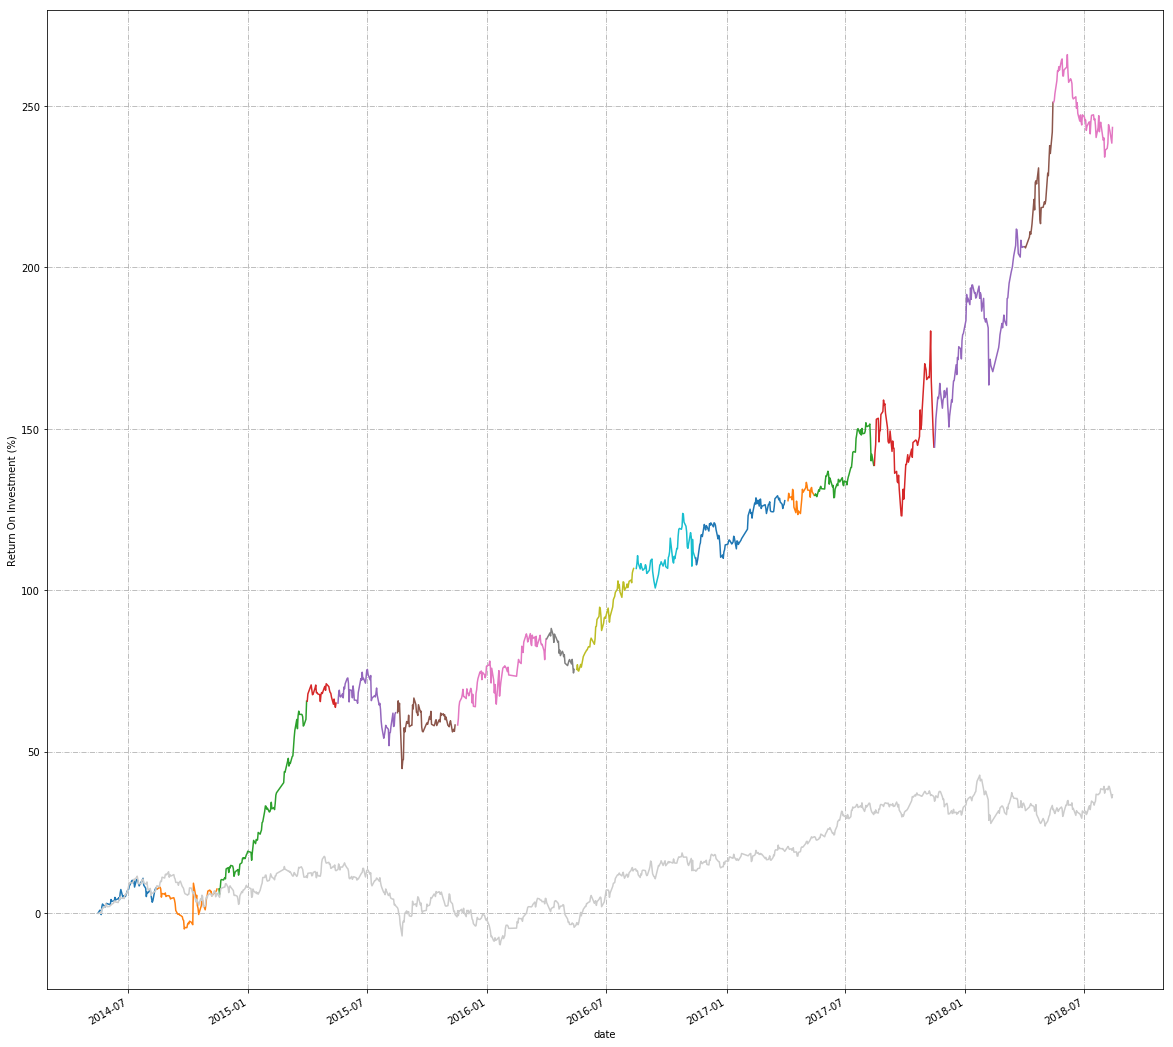

Win Ratio：0.5761589403973509
Expected Payoff：0.0794273366854417
Profit Factor：3.0518997914042227
Recovery Factor：13.920354004047711
Sharpe Ratio：0.32143832200039235


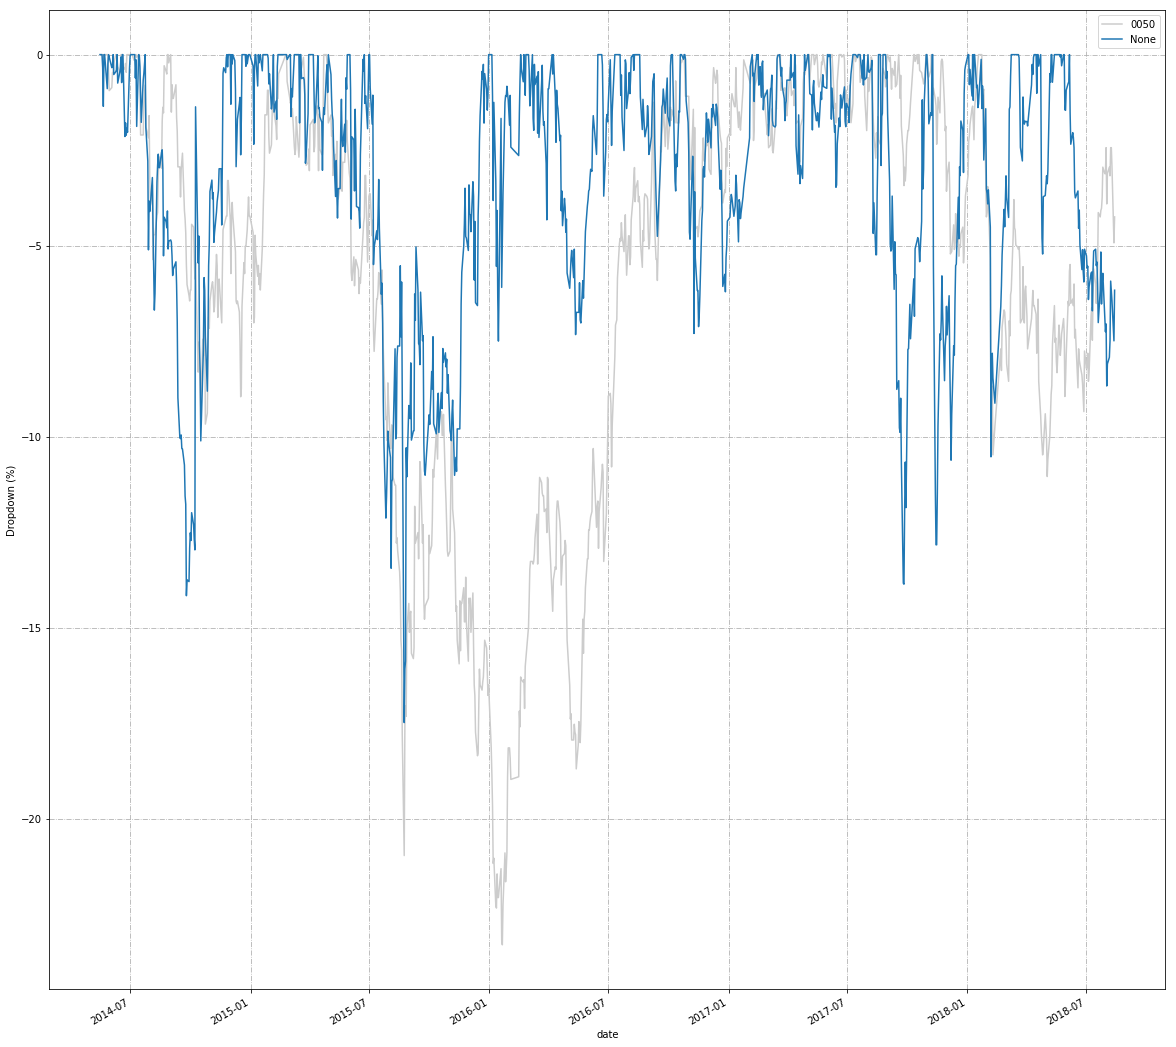

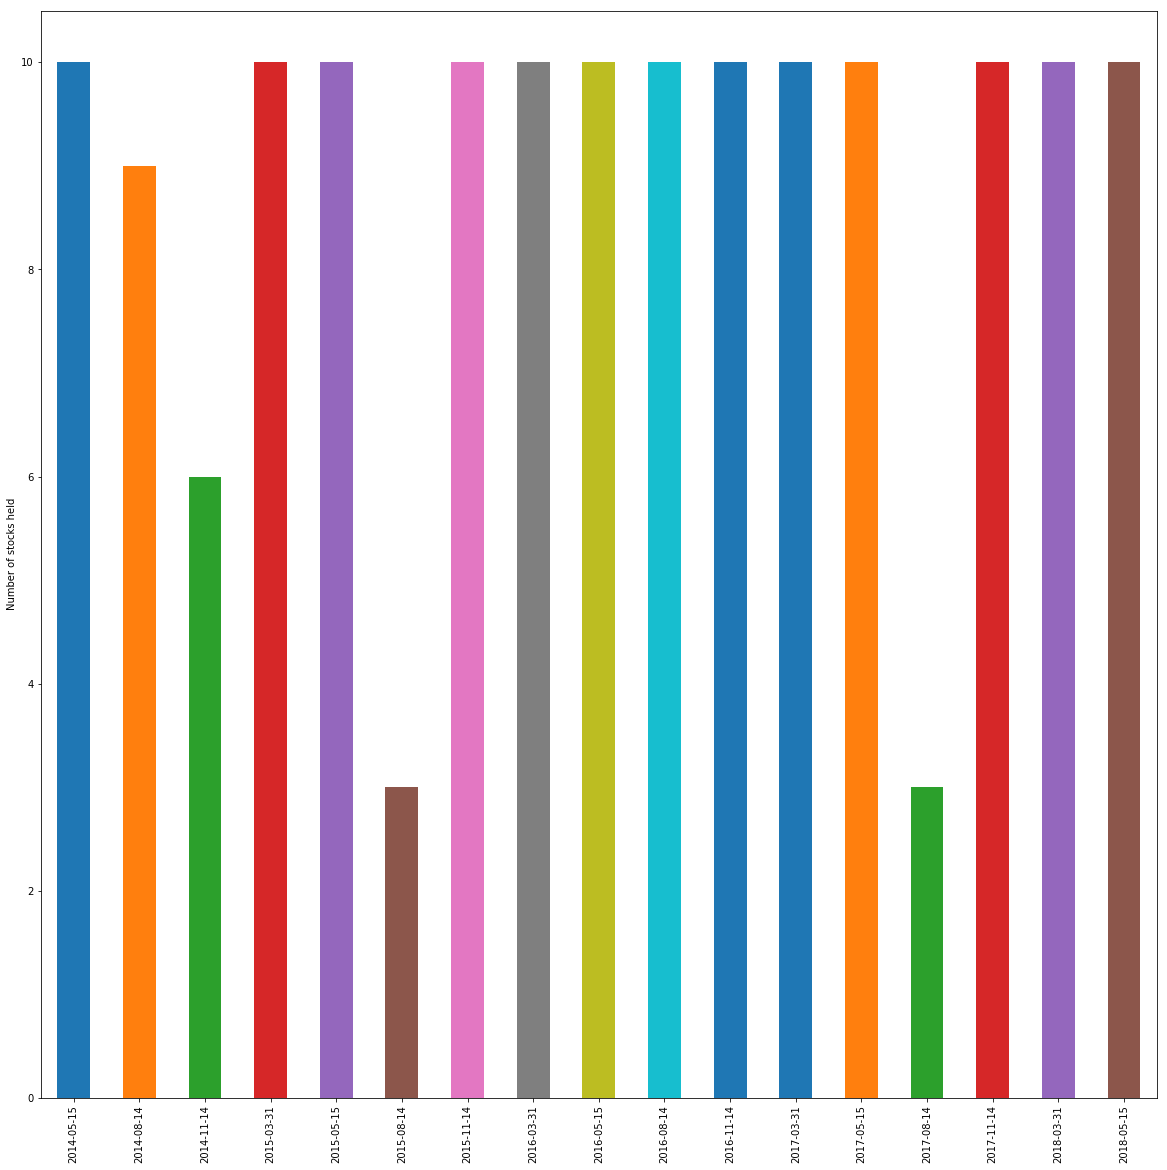

In [15]:
from finlab.backtest import backtest

list_dates = [datetime.date(2014, 5, 15), datetime.date(2014, 8, 14), datetime.date(2014, 11, 14),
              datetime.date(2015, 3, 31), datetime.date(2015, 5, 15), datetime.date(2015, 8, 14), datetime.date(2015, 11, 14),
              datetime.date(2016, 3, 31), datetime.date(2016, 5, 15), datetime.date(2016, 8, 14), datetime.date(2016, 11, 14),
              datetime.date(2017, 3, 31), datetime.date(2017, 5, 15), datetime.date(2017, 8, 14), datetime.date(2017, 11, 14),
              datetime.date(2018, 3, 31), datetime.date(2018, 5, 15), datetime.date(2018, 8, 14)]
equality, transections = backtest(datetime.date(2014, 5, 15), datetime.date(2018, 8, 14), list_dates, ModERP, data, stop_loss=None)

### 7. 根據王睿麒大大的指導，繪出 [MAE 與 Profit-Loss 圖](https://docs.google.com/presentation/d/1o-tSWGh-a2JgPtHuMXWr4fT5KMUAK9CzaWqWDJnW5Ng/edit#slide=id.g42f9e08b6c_0_254)，尋找該策略合適的停損點

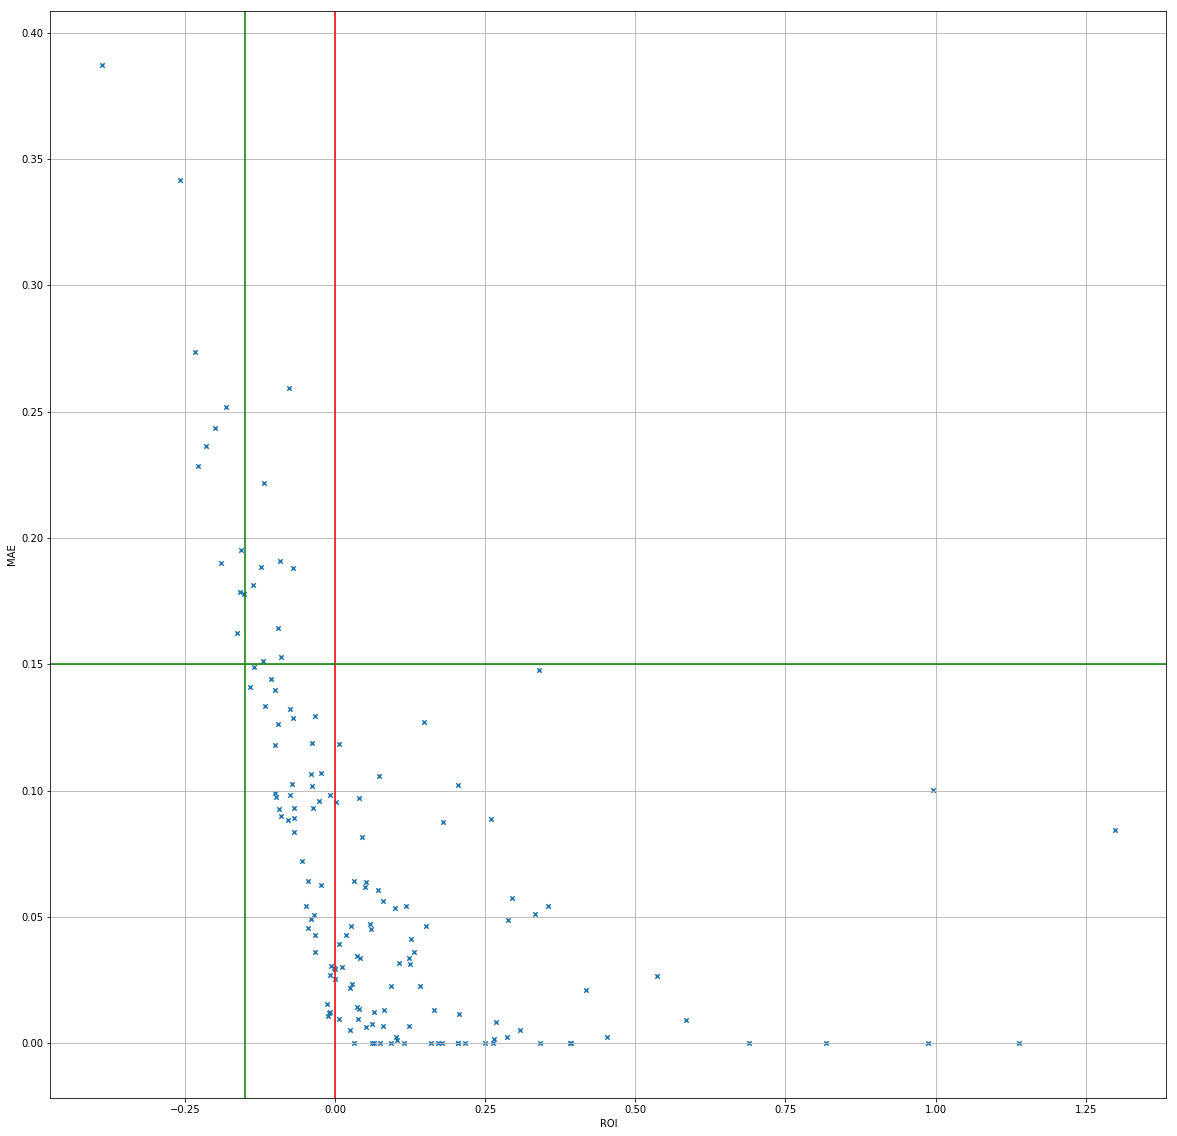

In [10]:
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize']=(20, 20)

transections.plot.scatter(x='ROI', y='MAE', marker='x', grid=True)
plt.axvline(x=0, color='r')
plt.axvline(x=-0.15, color='g')
plt.axhline(y=0.15, color='g')

7.1 由 [MAE 與 Profit-Loss 的分佈圖](https://docs.google.com/presentation/d/1o-tSWGh-a2JgPtHuMXWr4fT5KMUAK9CzaWqWDJnW5Ng/edit#slide=id.g42f9e08b6c_0_254) 可以得知，若將停損點設定在 -15%，不會讓任何最終有獲利的交易打入虧損（因為最終有獲利的交易 MAE 都無超過 15%）。
<br/>
因此先將停損點設定為 -15%，再進行一次回測。

2014-05-15 - 2014-08-14 報酬率: 6.36 % number of stocks 10
2014-08-14 - 2014-11-14 報酬率: -1.45 % number of stocks 9
2014-11-14 - 2015-03-31 報酬率: 54.11 % number of stocks 6
2015-03-31 - 2015-05-15 報酬率: -0.36 % number of stocks 10
2015-05-15 - 2015-08-14 報酬率: -3.04 % number of stocks 10
2015-08-14 - 2015-11-14 報酬率: -2.35 % number of stocks 3
2015-11-14 - 2016-03-31 報酬率: 16.89 % number of stocks 10
2016-03-31 - 2016-05-15 報酬率: -4.71 % number of stocks 10
2016-05-15 - 2016-08-14 報酬率: 17.82 % number of stocks 10
2016-08-14 - 2016-11-14 報酬率: 3.74 % number of stocks 10
2016-11-14 - 2017-03-31 報酬率: 8.46 % number of stocks 10
2017-03-31 - 2017-05-15 報酬率: 0.27 % number of stocks 10
2017-05-15 - 2017-08-14 報酬率: 4.56 % number of stocks 10
2017-08-14 - 2017-11-14 報酬率: 1.52 % number of stocks 3
2017-11-14 - 2018-03-31 報酬率: 25.09 % number of stocks 10
2018-03-31 - 2018-05-15 報酬率: 14.59 % number of stocks 10
2018-05-15 - 2018-08-14 報酬率: -3.01 % number of stocks 10
年化報酬 : 32.70 ％
每次換手最大報酬 : 54.11 ％
每次換手最少報

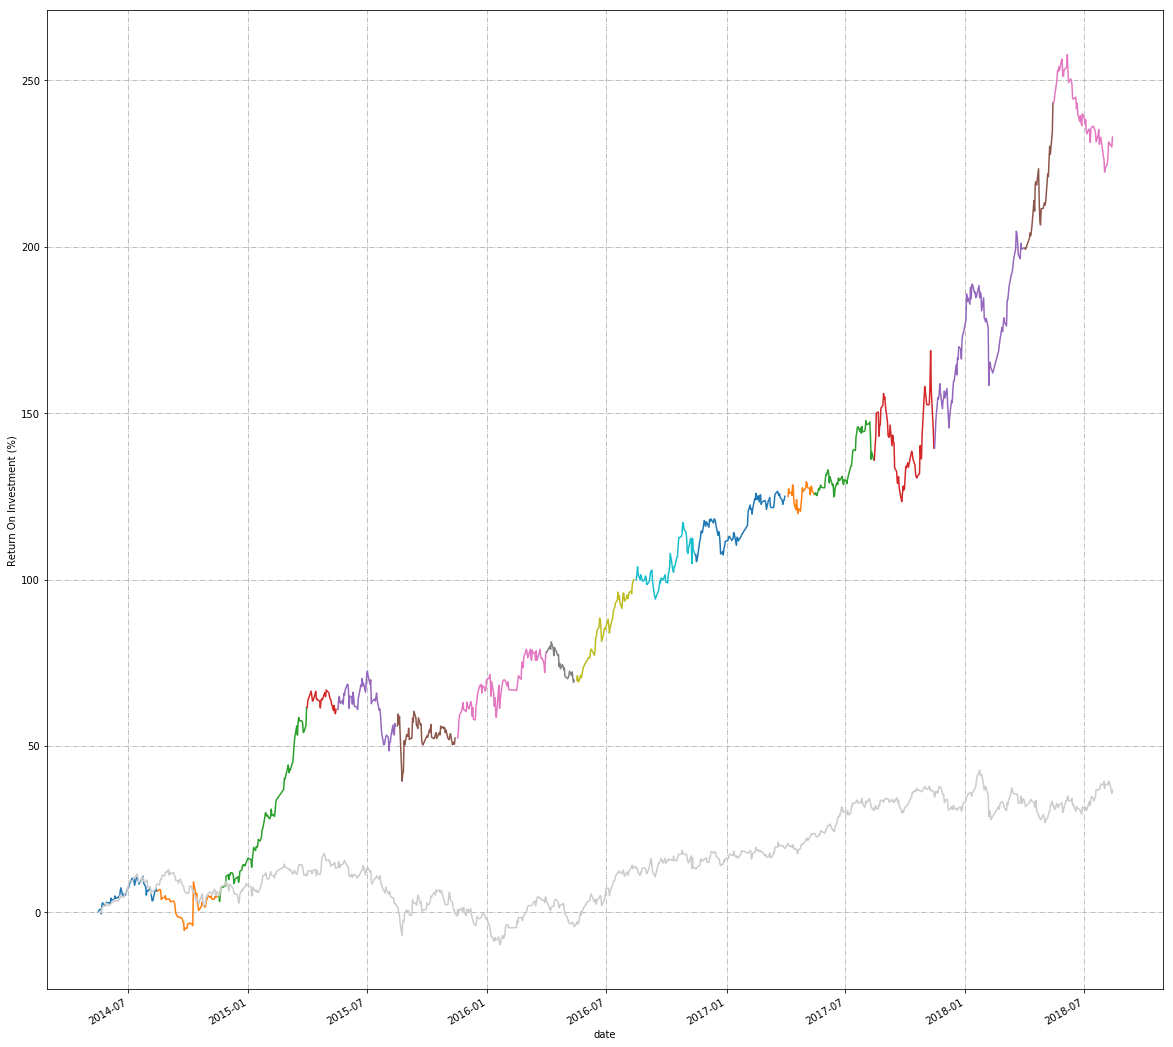

Win Ratio：0.5761589403973509
Expected Payoff：0.07785972666648208
Profit Factor：2.9331169901242182
Recovery Factor：12.142260005215542
Sharpe Ratio：0.31460578564295266


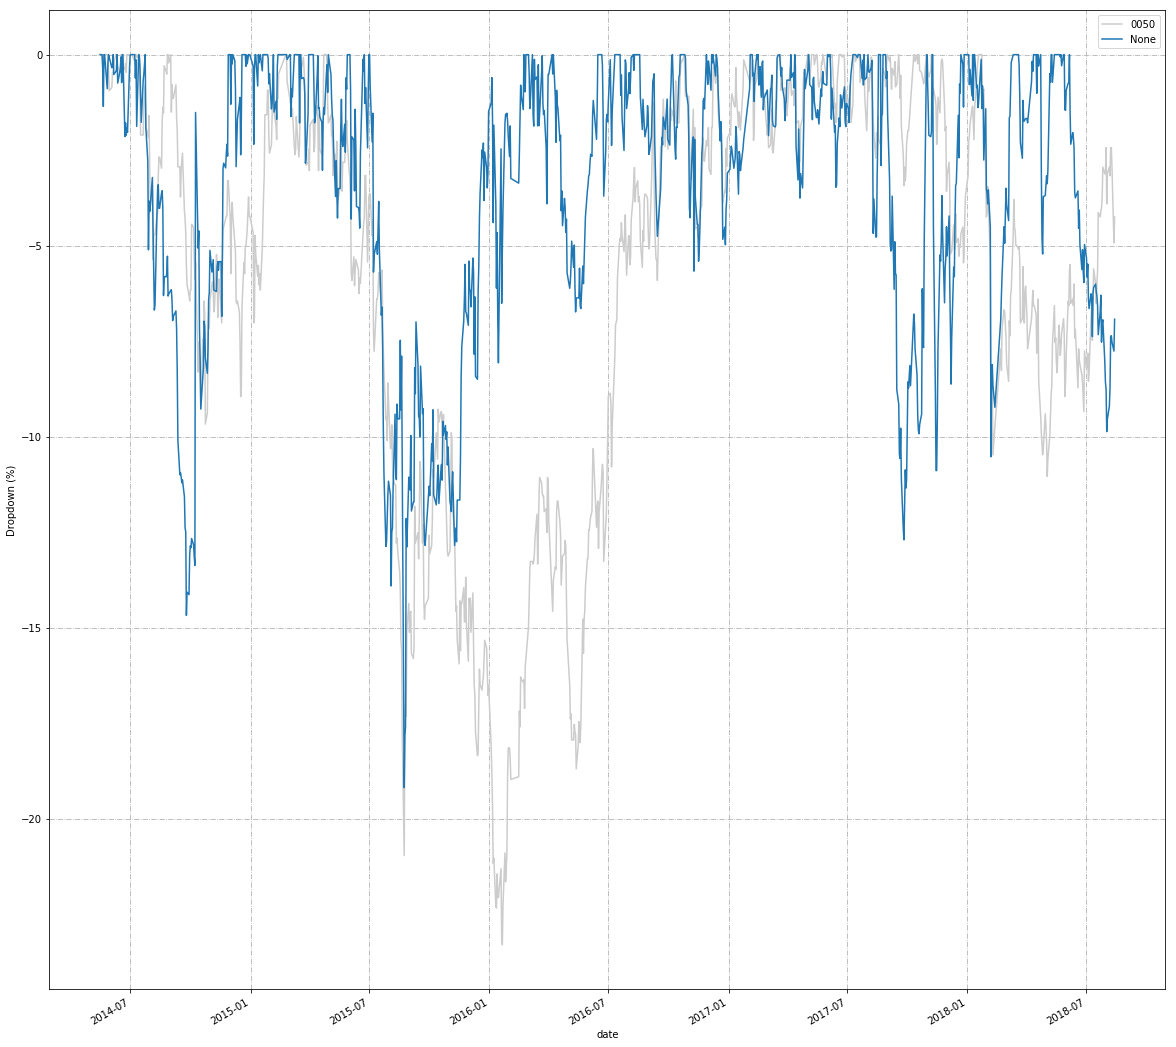

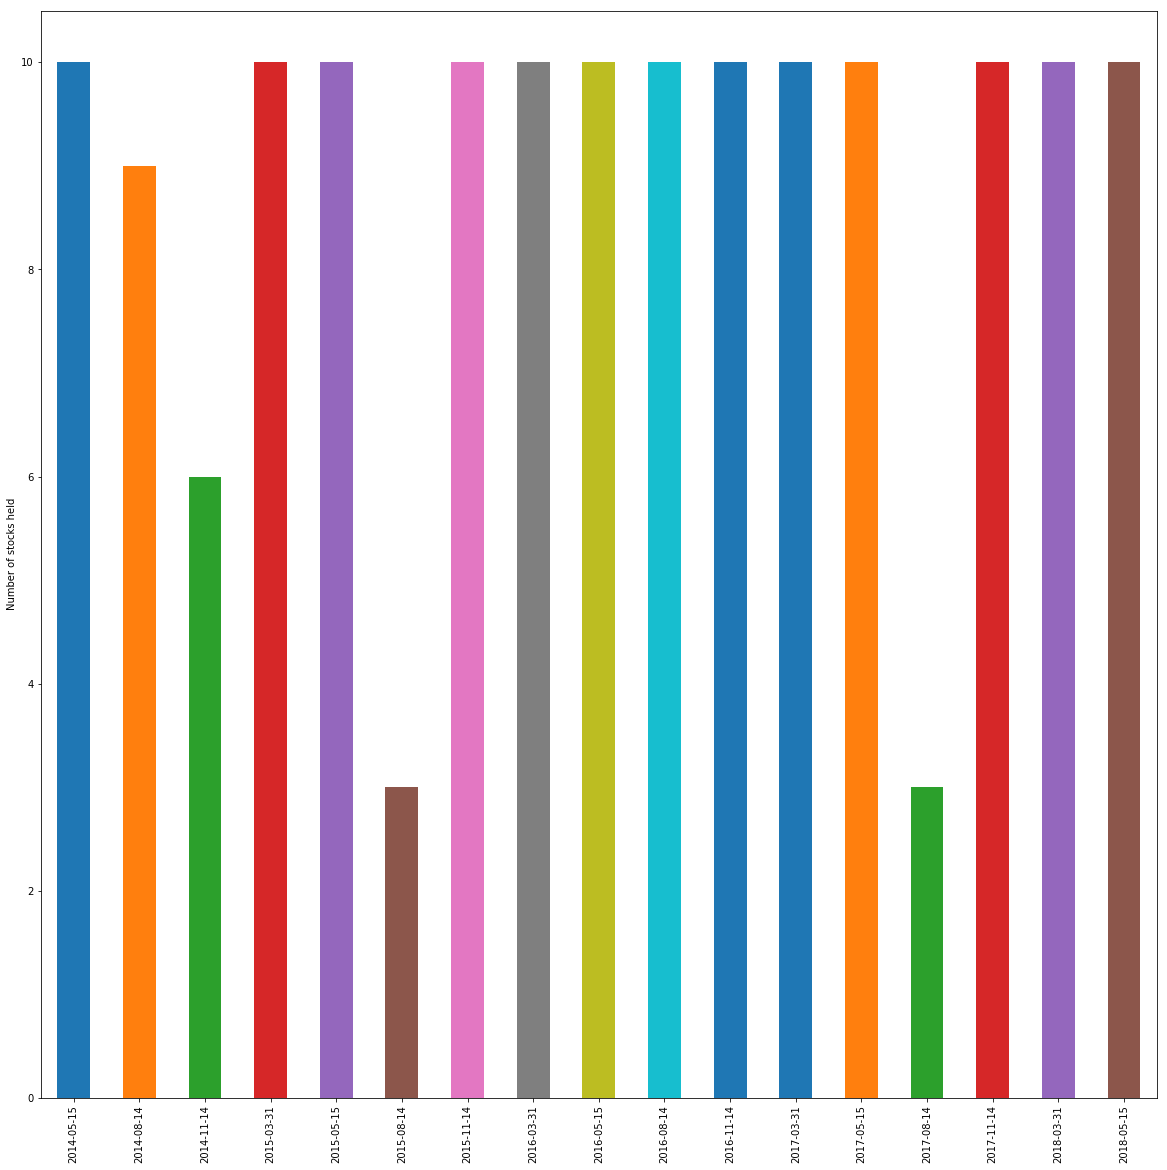

In [11]:
equality_v2, transections_v2 = backtest(datetime.date(2014, 5, 15), datetime.date(2018, 8, 14), list_dates, ModERP, data, stop_loss=0.15)

7.2 回測後年化報酬率降低為 32.7%（原本是 33.66%）。判斷降低的原因，是由於在原本虧損的交易中，那些 MAE >15%、但是最終虧損 <15% 的交易，會因為設定了 -15% 的停損點，導致全部虧損 15% 出場。

### 8. 為了更精確找出獲利與停損點之間的平衡，再根據王睿麒大大的指導，繪出 [MAE 與 Profit-Loss 的頻率圖](https://docs.google.com/presentation/d/1o-tSWGh-a2JgPtHuMXWr4fT5KMUAK9CzaWqWDJnW5Ng/edit#slide=id.g42f9e08b6c_0_464)。

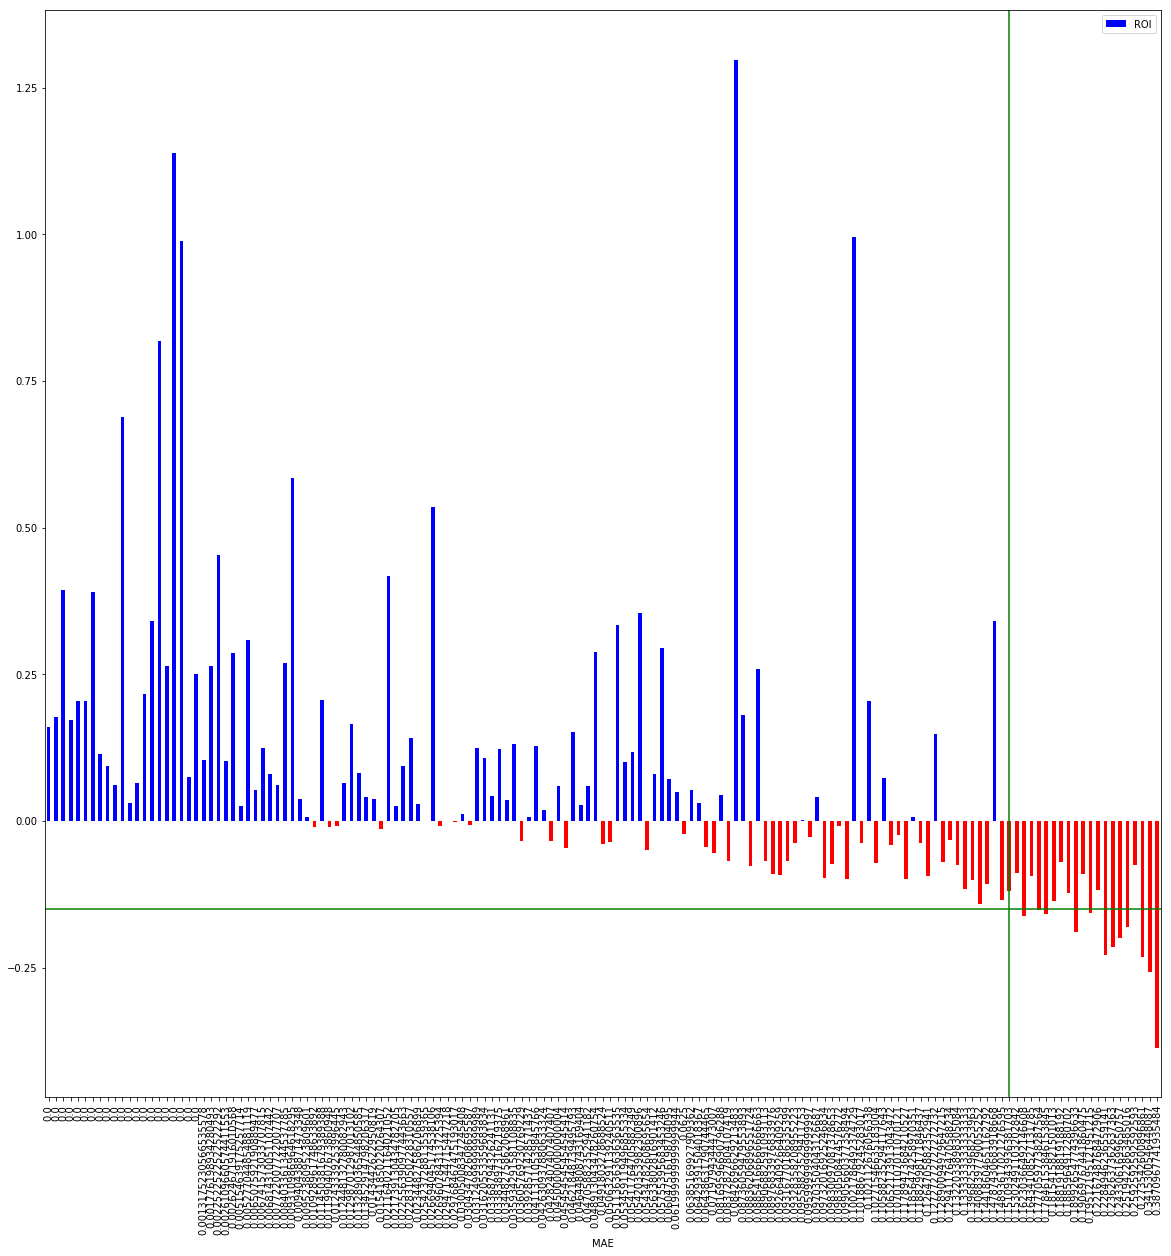

In [12]:
roi_to_mae = transections[['ROI','MAE']].sort_values(by=['MAE'])#.applymap(lambda data: round(data, 2)).sort_values(by=['MAE'])
roi_to_mae['color'] = 'b'
roi_to_mae.loc[roi_to_mae['ROI'] < 0, 'color'] = 'r'
roi_to_mae.plot.bar(x='MAE', y='ROI', color=roi_to_mae['color'])

plt.axvline(x=130, color='g')
plt.axhline(y=-0.15, color='g')

8.1 由 [MAE 與 Profit-Loss 的頻率圖](https://docs.google.com/presentation/d/1o-tSWGh-a2JgPtHuMXWr4fT5KMUAK9CzaWqWDJnW5Ng/edit#slide=id.g42f9e08b6c_0_464) 可以發現，若將停損點設定在 -15%，右下角紅色長條圖的綠色水平線上方的面積都會全部被填滿，因為會強制停損。
<br/>
現在我們知道若要將利潤最大化，目標是求水平零軸以下、至綠色水平線（停損點）的面積最小。

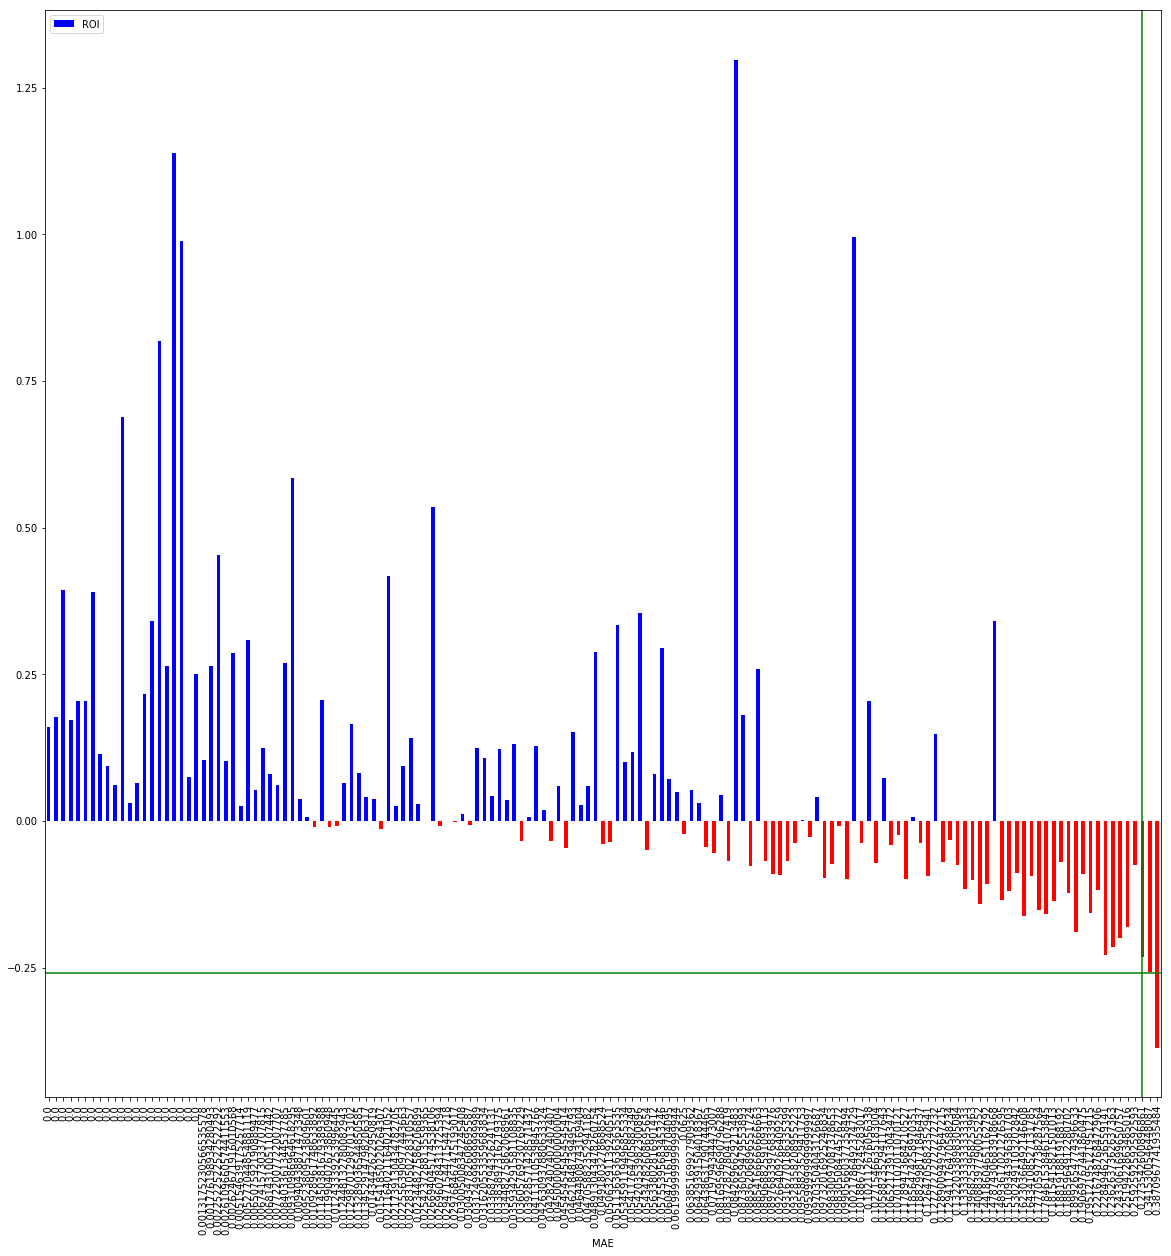

In [13]:
roi_to_mae.plot.bar(x='MAE', y='ROI', color=roi_to_mae['color'])

plt.axvline(x=148, color='g')
plt.axhline(y=-0.26, color='g')

8.2 最後找到使虧損面積最小的停損點為 -26%，再進行一次回測。

2014-05-15 - 2014-08-14 報酬率: 7.54 % number of stocks 10
2014-08-14 - 2014-11-14 報酬率: -0.95 % number of stocks 9
2014-11-14 - 2015-03-31 報酬率: 54.11 % number of stocks 6
2015-03-31 - 2015-05-15 報酬率: -0.36 % number of stocks 10
2015-05-15 - 2015-08-14 報酬率: -1.80 % number of stocks 10
2015-08-14 - 2015-11-14 報酬率: -2.35 % number of stocks 3
2015-11-14 - 2016-03-31 報酬率: 16.83 % number of stocks 10
2016-03-31 - 2016-05-15 報酬率: -5.10 % number of stocks 10
2016-05-15 - 2016-08-14 報酬率: 17.82 % number of stocks 10
2016-08-14 - 2016-11-14 報酬率: 2.74 % number of stocks 10
2016-11-14 - 2017-03-31 報酬率: 8.46 % number of stocks 10
2017-03-31 - 2017-05-15 報酬率: 0.72 % number of stocks 10
2017-05-15 - 2017-08-14 報酬率: 4.05 % number of stocks 10
2017-08-14 - 2017-11-14 報酬率: 2.37 % number of stocks 3
2017-11-14 - 2018-03-31 報酬率: 25.39 % number of stocks 10
2018-03-31 - 2018-05-15 報酬率: 14.59 % number of stocks 10
2018-05-15 - 2018-08-14 報酬率: -2.22 % number of stocks 10
年化報酬 : 33.73 ％
每次換手最大報酬 : 54.11 ％
每次換手最少報

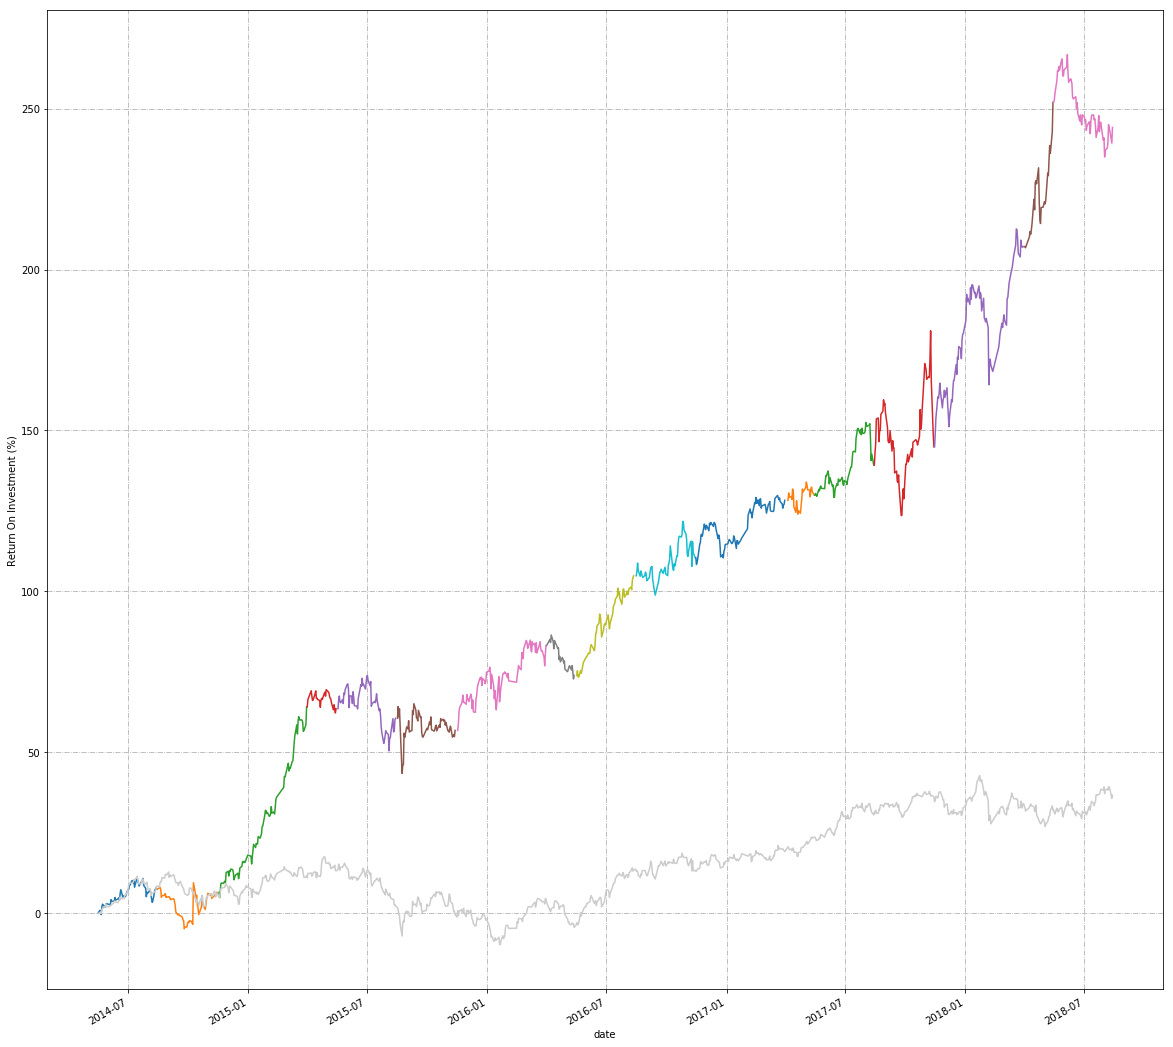

Win Ratio：0.5761589403973509
Expected Payoff：0.07965924744395053
Profit Factor：3.0702942514020384
Recovery Factor：13.965224124425342
Sharpe Ratio：0.32305378562622195


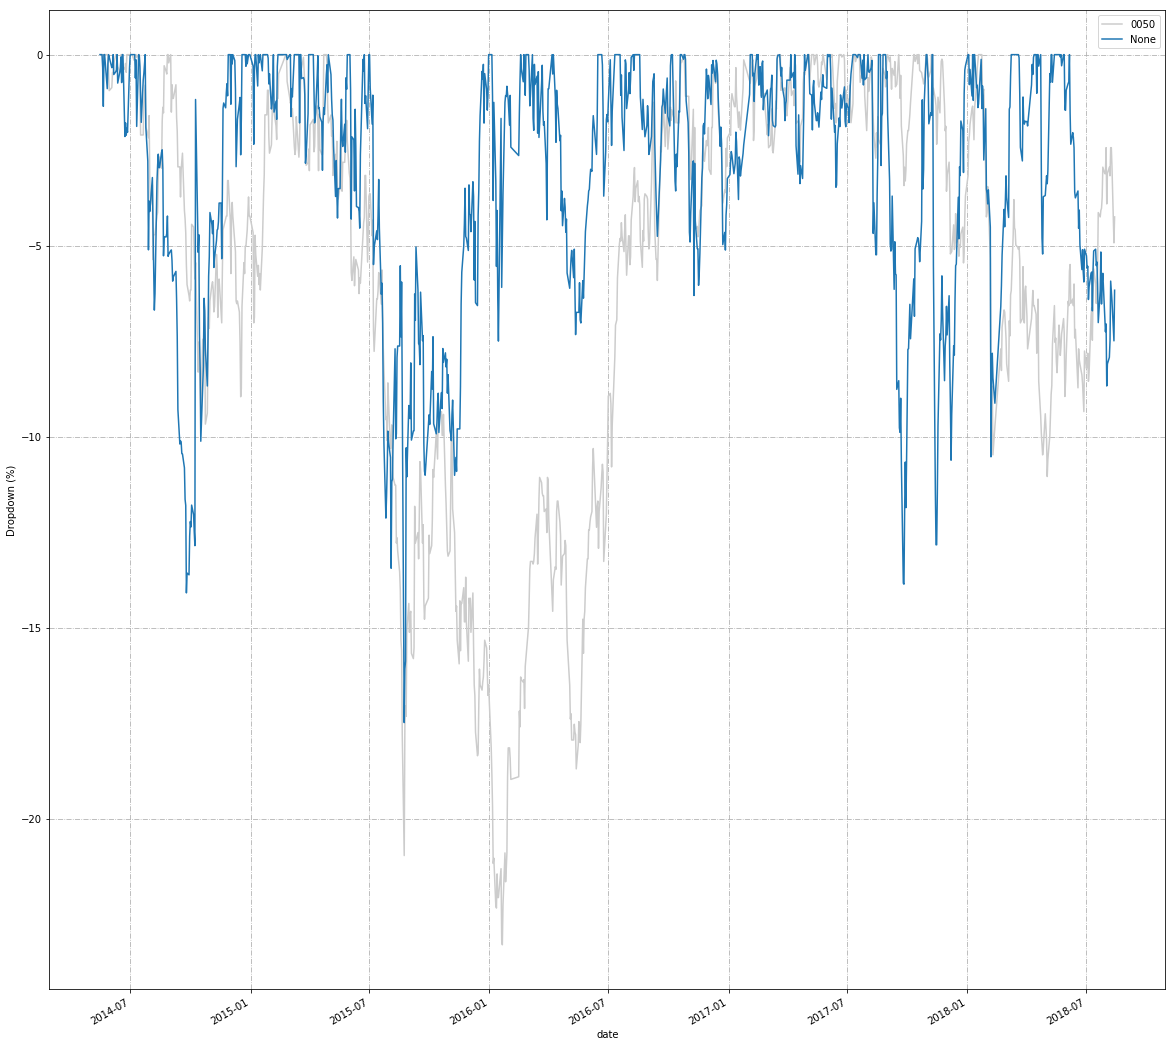

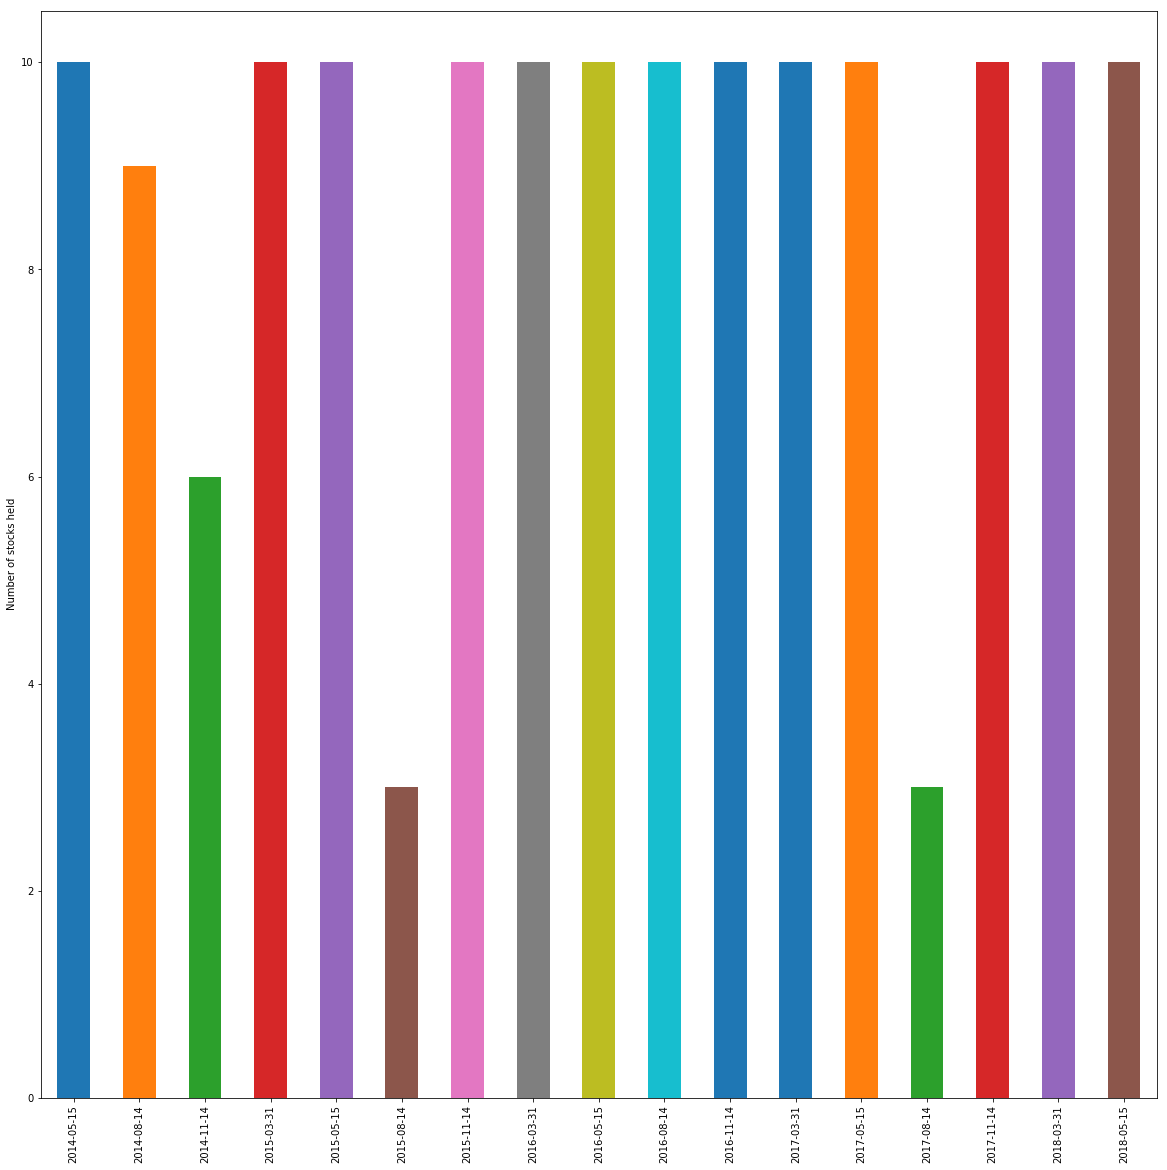

In [14]:
equality_v3, transections_v3 = backtest(datetime.date(2014, 5, 15), datetime.date(2018, 8, 14), list_dates, ModERP, data, stop_loss=0.26)

### 9. 最後年化報酬率為 33.73%（原本是 33.66%），提高了 0.07%

### 10. 後記